In [3]:
import pandas as pd
import numpy as np
import re
import nltk

nltk.download('punkt')     # для токенизации
nltk.download('stopwords')  # для списка стоп-слов

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\david\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


# Текстовый анализ

In [4]:
df = pd.read_excel(r'C:\Users\david\Downloads\Telegram Desktop\Данные от экспертов.xlsx')

In [5]:
df.head()

,Длительность,Простои,Причина,Общее описание
0,20.416666,Переналадки,Переход продукт вода продукт,Переход продукт вода продукт + АПМ
1,21.700000,Переналадки,Переход продукт вода продукт,Переход продукт вода продукт + АПМ
2,29.433333,Прочие внеплановые простои,Загруженность склада,Съем ГП
3,8.733333,Прочие внеплановые простои,Загруженность склада,Съем ГП
4,2.350000,Прочие внеплановые простои,Загруженность склада,Съем ГП


In [6]:
#чистка от всяких знаков + нижнйи регистр
for i in df.columns[1:]:
    df[i] = df[i].apply(lambda x: re.sub(r'[\d\.\:\)\(\+\-\\\/]', '', x.lower()))



In [7]:
#список стоп слов
stopwords = set(stopwords.words("russian"))
#токенизатор который извлекает только слова
tokenizer = RegexpTokenizer(r'\b\w+\b')

def tokenize_fun(text):
    if isinstance(text, str):
        tokens = tokenizer.tokenize(text)
        filtered_tokens = [token for token in tokens if token not in stopwords and len(token) > 1]
        return filtered_tokens
    return []


In [8]:
#токенизирую

for i in df.columns[1:]:
    df[i] = df[i].apply(tokenize_fun)


In [9]:
df.head(3)

,Длительность,Простои,Причина,Общее описание
0,20.416666,[переналадки],"[переход, продукт, вода, продукт]","[переход, продукт, вода, продукт, апм]"
1,21.700000,[переналадки],"[переход, продукт, вода, продукт]","[переход, продукт, вода, продукт, апм]"
2,29.433333,"[прочие, внеплановые, простои]","[загруженность, склада]","[съем, гп]"


In [12]:
import pymorphy3

#лемматихатор
morph = pymorphy3.MorphAnalyzer()

def lemmatize_tokens(tokens):
    return [morph.parse(token)[0].normal_form for token in tokens]

In [13]:
for i in df.columns[1:]:
    df[i] = df[i].apply(lemmatize_tokens)

In [14]:
df.head()

,Длительность,Простои,Причина,Общее описание
0,20.416666,[переналадка],"[переход, продукт, вода, продукт]","[переход, продукт, вода, продукт, апм]"
1,21.700000,[переналадка],"[переход, продукт, вода, продукт]","[переход, продукт, вода, продукт, апм]"
2,29.433333,"[прочий, внеплановый, простой]","[загруженность, склад]","[съесть, гп]"
3,8.733333,"[прочий, внеплановый, простой]","[загруженность, склад]","[съесть, гп]"
4,2.350000,"[прочий, внеплановый, простой]","[загруженность, склад]","[съесть, гп]"


In [15]:
df['combined_text'] = df[['Простои', 'Причина', 'Общее описание']].apply(lambda x: ' '.join(sum(x, [])), axis=1)

In [16]:
df.drop(columns=df.columns[1:-1], inplace=True)

In [135]:
#TF-IDF - метод который позволяет оценить важность слов в тексте учитывая не
#только частоту в документе но и то насколько часто оно встречается в других доках

#TF = число вхожений слова в доке / общее число слов в документе

#так как в наблюдениях не наблюдается повторений, примню мешок слов


In [17]:
vectorizer = CountVectorizer()

X = vectorizer.fit_transform(df['combined_text'])

In [18]:
#список уникальных слов
uniq_woerds = vectorizer.get_feature_names_out()
frequencies_data = X.toarray()

In [19]:
df[uniq_woerds] = frequencies_data

In [20]:
df.drop('combined_text', axis=1, inplace=True)

In [21]:
df.head(3)

,Длительность,апм,бутылкибанк,внеплановый,внешний,вода,время,втора,гп,дезинфекция,...,тот,укупор,упак,услуга,цветапечатиакциз,час,шт,щк,экспортпромый,этикетка
0,20.416666,1,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,21.700000,1,0,0,0,2,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,29.433333,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [152]:
#persentiles = [20, 40, 60, 80]
#borders = []

#for i in persentiles:
#  borders.append(np.percentile(df['Длительность'], i))


In [22]:
from sklearn.cluster import KMeans

In [23]:
df['Длительность_стандартизация'] = (df['Длительность'] - df['Длительность'].mean()) / df['Длительность'].std()  # стандартизация


In [24]:
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)

In [25]:
df['cluster'] = kmeans.fit_predict(df.iloc[:, 1:])

In [26]:
df['cluster'].value_counts()

0    98
3    96
1    79
4    52
2    21
Name: cluster, dtype: int64

In [27]:
df.groupby('cluster')['Длительность'].mean()

cluster
0     18.962925
1     12.829536
2    201.317460
3      9.823090
4     83.800641
Name: Длительность, dtype: float64

In [30]:
#средняя длительность простоев по кластеру
avg_downtime = df.groupby('cluster')['Длительность'].mean()

cluster
0     18.962925
1     12.829536
2    201.317460
3      9.823090
4     83.800641
Name: Длительность, dtype: float64

In [31]:
cluster_colors = {
    0: "blue",
    1: "green",
    2: "red",
    3: "purple",
    4: "orange",
    5: "brown",
    6: "pink"
}

# функция для назначения цвета словам в зависимости от кластера
def color_func(cluster):
    def func(word, font_size, position, orientation, random_state=None, **kwargs):
        return cluster_colors.get(cluster, "black")  # Цвет по номеру кластера
    return func

In [35]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [46]:
df_ex = df.loc[:, df.columns[1:-2]]

In [50]:
df[df['cluster'] == 0].iloc[:, 1:-2]

,апм,бутылкибанк,внеплановый,внешний,вода,время,втора,гп,дезинфекция,дизайн,...,тот,укупор,упак,услуга,цветапечатиакциз,час,шт,щк,экспортпромый,этикетка
0,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
15,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
312,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
320,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
326,1,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
(((np.sum(df_ex[df_ex['cluster'] == cluster], axis=0))
                     .to_frame())
                     .iloc[:-1, :]
                     .sort_values(by=0, ascending=False))

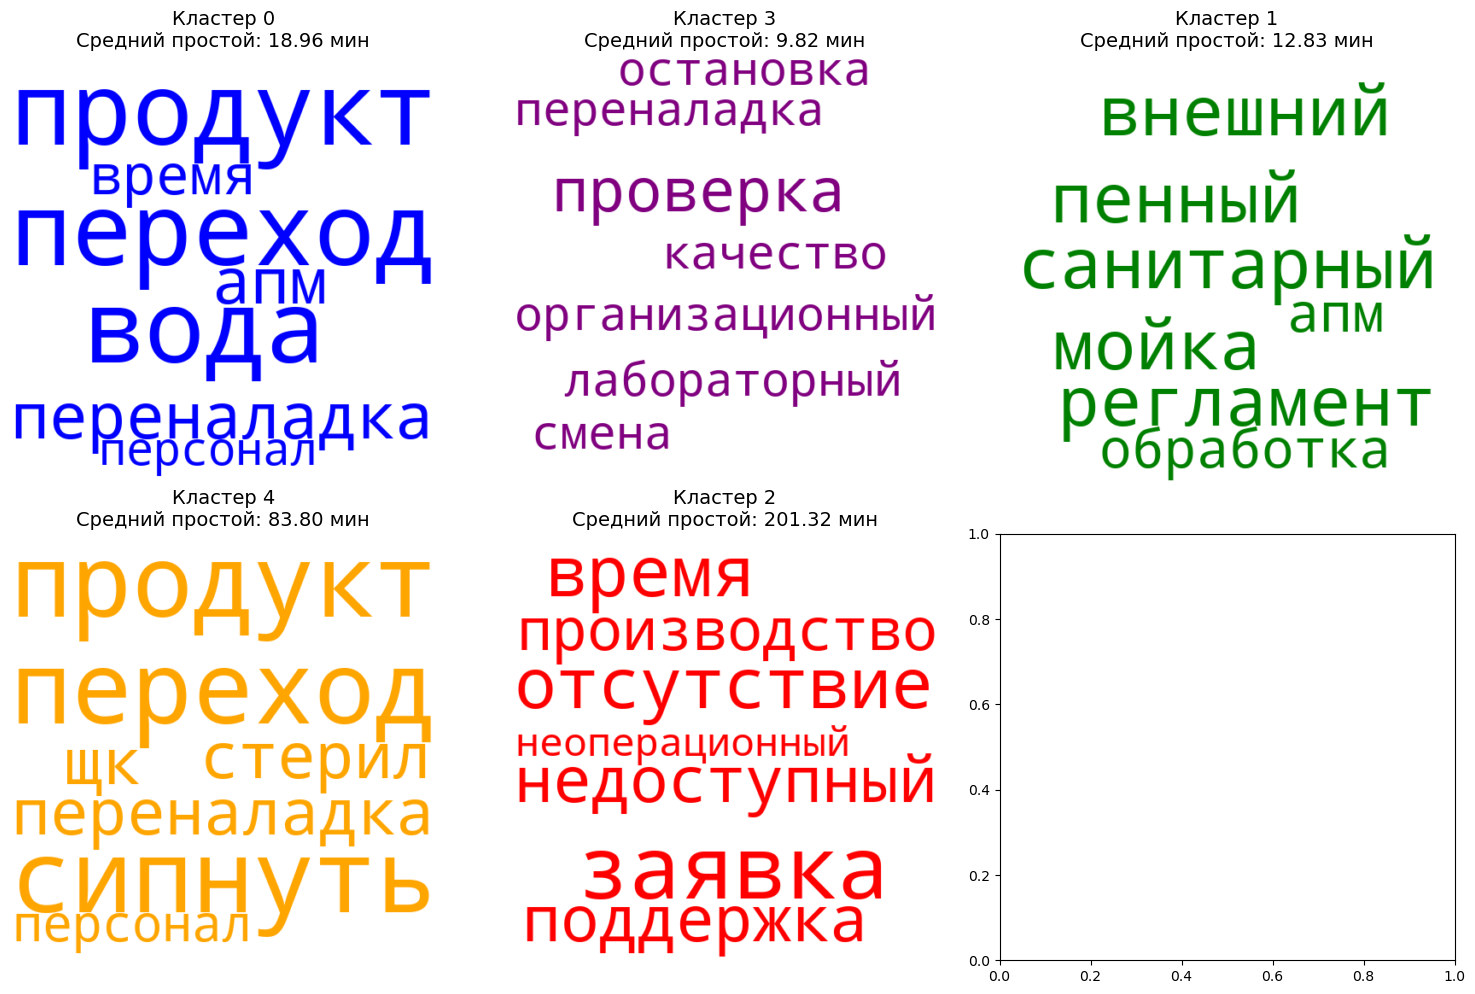

In [54]:
num_clusters = len(df['cluster'].unique())  # Количество кластеров
fig, axes = plt.subplots(2, (num_clusters + 1) // 2, figsize=(15, 10))  # Динамическое количество подграфиков
axes = axes.flatten()


for idx, cluster in enumerate(df['cluster'].unique()):
    df_ex = df[df['cluster'] == cluster].iloc[:, 1:-2]
    top_percent = (((np.sum(df_ex, axis=0))
                     .to_frame())
                     .iloc[:-1, :]
                     .sort_values(by=0, ascending=False))

    # Выбираем топ-10% слов
    top_words = top_percent.iloc[:int(len(top_percent) * 0.1)].index.tolist()
    
    # Создаём строку со словами (повторяем слово в зависимости от его важности)
    word_string = " ".join(top_words)
    
    # Генерируем облако слов
    wordcloud = WordCloud(
        width=500, height=500, 
        background_color="white",
        colormap="viridis",
        color_func=color_func(cluster)
    ).generate(word_string)
    
    # Рисуем облако слов
    axes[idx].imshow(wordcloud, interpolation="bilinear")
    axes[idx].set_title(f"Кластер {cluster}\nСредний простой: {avg_downtime[cluster]:.2f} мин", fontsize=14)
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

In [ ]:
df = pd.read_excel('/content/beer_features.xlsx', header=3).dropna(axis=1, how='all')
main_features = pd.read_excel('/content/beer_features_main.xlsx', header=3).dropna(axis=1, how='all')

In [ ]:
main_features['Статус'] =  main_features['Статус'].astype('category').cat.codes

In [ ]:
main_features['Время начала интервала']

,Время начала интервала
0,2024-07-01 08:00:00
1,2024-07-01 08:13:00
2,2024-07-01 08:13:00
3,2024-07-01 08:18:00
4,2024-07-01 09:17:00
...,...
6639,2024-07-31 00:18:00
6640,2024-07-31 00:48:00
6641,2024-07-31 00:50:00
6642,2024-07-31 01:21:00


In [ ]:
from datetime import datetime

# main_features['Время начала интервала'] = main_features['Время начала интервала'].apply(lambda x: datetime.strptime(x, '%d/%m/%Y %H:%M'))
main_features['День недели'] = main_features['Время начала интервала'].dt.weekday

In [ ]:
main_features

,Время начала интервала,Время окончания интервала,Длительность,Линия,Оборудование,Статус,День недели
0,2024-07-01 08:00:00,01/07/2024 08:13,13.400000,CL4,Блок розлива (CL4),10,0
1,2024-07-01 08:13:00,01/07/2024 08:13,0.183333,CL4,Блок розлива (CL4),1,0
2,2024-07-01 08:13:00,01/07/2024 08:18,4.433333,CL4,Блок розлива (CL4),9,0
3,2024-07-01 08:18:00,01/07/2024 09:17,59.100000,CL4,Блок розлива (CL4),10,0
4,2024-07-01 09:17:00,01/07/2024 09:18,1.016666,CL4,Блок розлива (CL4),2,0
...,...,...,...,...,...,...,...
6639,2024-07-31 00:18:00,31/07/2024 00:48,30.016666,CL4,Блок розлива (CL4),10,2
6640,2024-07-31 00:48:00,31/07/2024 00:50,2.000000,CL4,Блок розлива (CL4),9,2
6641,2024-07-31 00:50:00,31/07/2024 01:21,31.516666,CL4,Блок розлива (CL4),10,2
6642,2024-07-31 01:21:00,31/07/2024 01:22,0.316666,CL4,Блок розлива (CL4),9,2


In [ ]:
def categorize_time(hour):
    if 5 <= hour < 12:
        return 0
    elif 12 <= hour < 17:
        return 1
    elif 17 <= hour < 22:
        return 2
    else:
        return 3

# Apply the function to create a new column with time categories
df['Время дня'] = df['Время начала интервала'].apply(categorize_time)

   hour  minute  hour_sin  hour_cos  minute_sin  minute_cos
0    20      42 -0.866025       0.5   -0.951057   -0.309017


In [ ]:
prostoi = pd.get_dummies(df['Простои'])
prichina = pd.get_dummies(df['Причина'])
obshee_opisanie = pd.get_dummies(df['Общее описание'])
component = pd.get_dummies(df['Компонент'])
# print(len(df['Простои'].unique()))
# print(len(df['Причина'].unique()))
# print(len(df['Общее описание'].unique()))
# print(len(df['Детальное описание'].unique()))
# print(len(df['Компонент'].unique()))


146
3


In [ ]:
obshee_opisanie

,АПМ (Пенная санитарная обработка),Дезинфекция,Изм-е дизайна (цвета/печати/акциз),Лабораторные проверки,Малые остановки,Ополаскивание укупора и розлива,Отсутствие заявок,ПТО,Переход продукт вода продукт,Переход продукт вода продукт + АПМ,...,Прогон в 00:00 часов,Продукт СИП щ-к продукт,Продукт СИП щ. продукт,Продукт стерил. продукт,Смена дизайна (экспорт/промо),Смена расходных материалов,Съем ГП,"Та же машина, разное кол-во рядов, разное кол-во шт.",Тесты материалов,Услуги подрядных организаций
0,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
342,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
343,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
344,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
